Consider a simplified model of an enzymatic reaction where the enzyme-substrate binding step is irreversible:
$$E + S \overset{k_1}{\longrightarrow} C \overset{k_2}{\longrightarrow} E + P$$

- Binding: $E + S \rightarrow C$ (propensity $a_1 = k_1 ⋅ E ⋅ S$)
- Catalysis: $C \rightarrow E + P$ (propensity $a_2 = k_2 ⋅ C$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import matplotlib
import scipy

print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"SciPy version: {scipy.__version__}")

NumPy version: 2.0.1
Matplotlib version: 3.10.5
SciPy version: 1.15.3


In [2]:
# 1. Parameters
k1, k2 = 0.001, 0.5
E0, S0, C0, P0 = 100, 1000, 0, 0
t_end = 20

n_runs = 500

t_grid = np.linspace(0, t_end, 200)

S_interp_all = []

In [3]:
# 2. Gillespie simulation
def gillespie_simulation(k1, k2, E0, S0, C0, P0, t_end):
    # initialization
    t, E, S, C, P = 0, E0, S0, C0, P0
    times = [t]
    Ss = [S]
    
    while t < t_end and S > 0:
        a1 = k1 * E * S   # E + S -> C
        a2 = k2 * C       # C -> E + P
        a0 = a1 + a2
        
        if a0 == 0:
            break
        
        r1, r2 = np.random.random(2)
        # Δt
        tau = np.log(1/r1) / a0
        # Determine which reaction occurs
        if r2 * a0 < a1:
            # E + S -> C
            if E > 0 and S > 0:
                E -= 1 
                S -= 1
                C += 1
            else:
                pass
        else:
            # C -> E + P
            if C > 0:
                C -= 1
                E += 1
                P += 1
            else:
                pass
        
        t += tau
        times.append(t)
        Ss.append(S)
    
    return np.array(times), np.array(Ss)

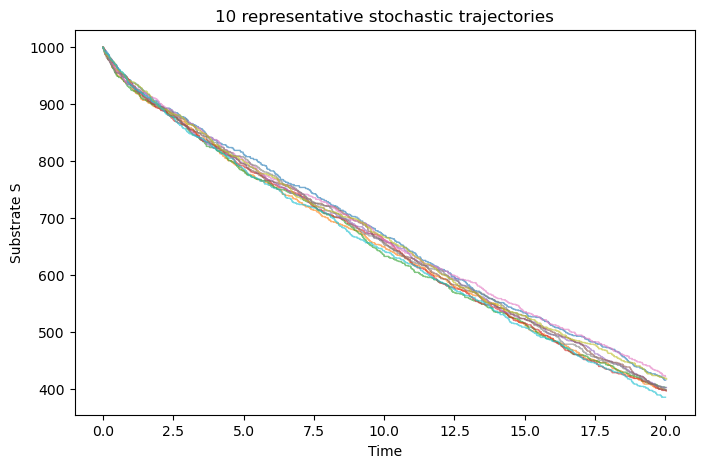

In [4]:
# 3. plot gillespie simulation
plt.figure(figsize=(8,5))
for i in range(n_runs):
    times, Ss = gillespie_simulation(k1, k2, E0, S0, C0, P0, t_end)
    f_interp = interp1d(times, Ss, kind='previous', 
                   bounds_error=False, fill_value=(Ss[0], Ss[-1]))
    S_interp_all.append(f_interp(t_grid))
    if i < 10:
        plt.step(times, Ss, where='post', alpha=0.6, lw=1)

plt.xlabel('Time')
plt.ylabel('Substrate S')
plt.title('10 representative stochastic trajectories')
plt.show()

In [ ]:
# 4. Mean Path
S_mean = np.mean(S_interp_all, axis=0)

In [6]:
# 5. Deterministic ODE Model
def ode_system(t, y):
    E, S, C, P = y
    dE_dt = -k1*E*S + k2*C
    dS_dt = -k1*E*S
    dC_dt = k1*E*S - k2*C
    dP_dt = k2*C
    return [dE_dt, dS_dt, dC_dt, dP_dt]

sol = solve_ivp(ode_system, [0, t_end], [E0, S0, C0, P0], t_eval=t_grid,
                method='RK45')

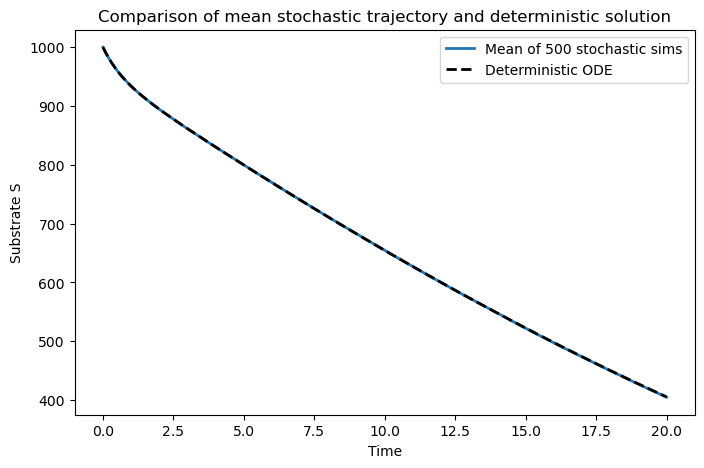

In [ ]:
# 6. Plotting the Mean Path vs. Deterministic Solution
plt.figure(figsize=(8,5))
plt.plot(t_grid, S_mean, label='Mean of 500 stochastic sims', lw=2)
plt.plot(sol.t, sol.y[1], 'k--', label='Deterministic ODE', lw=2)
plt.xlabel('Time')
plt.ylabel('Substrate S')
plt.legend()
plt.title('Comparison of mean stochastic trajectory and deterministic solution')
plt.show()

### Q&A

The relationship between the mean of the stochastic simulations and the deterministic solution: 
- The average value of the stochastic simulation is very close to the deterministic ODE solution.
- Individual random trajectories exhibit pronounced fluctuations, while the average value smoothly converges to a deterministic solution.

Reasons: 
- ODE is an approximation of the governing equation in the limit of a large number of molecules.
- The Gillespie algorithm reflects the dynamics of discrete, stochastic events.
- When the system is sufficiently large, the random average value will converge toward a deterministic solution according to the law of large numbers.

- In the later stages of the reaction, when the number of substrate molecules is low, some differences may be observed.
  - This is because: Random fluctuations become more pronounced at low molecular numbers; Discrete properties gain significance in continuous approximations.